# Bike Sharing Demand

## CRISP-DM Approach

CRISP-DM stands for Cross-Industry Standard Process for Data Mining and describes a structured approach to understanding, preparing, modeling and evaluating data. This process includes the following steps:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

Deployment is not relevant for this type of project, as I won't be deploying my model to a web server. However, my results will be summarized in a blog post on Medium (https://medium.com/@julia.nikulski).

### 1. Business Understanding

### 2. Data Understanding

The data set is similar to the bike sharing dataset provided by the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). However, the aforementioned dataset only contains data for 2011 and 2012. It was originally created by Fanaee-T and Gama (2013) in their study ["Event labeling combining ensemble detectors and background knowledge"](https://link.springer.com/article/10.1007/s13748-013-0040-3). 

To have a larger dataset, I collected the following data from the following sources for the time period of January 1, 2011 until December 31, 2018:
* The bike demand data comes from [Capital Bike Share](http://capitalbikeshare.com/system-data)
* The weather data was taken from [NOAA's National Climatic Data Center](https://www.ncdc.noaa.gov/cdo-web/search)
* The holiday data is from the [DC Department of Human Resources](http://dchr.dc.gov/page/holiday-schedule). 

The dataset uses data from the bike sharing stations of Capital Bike Share in Washington, D.C., USA. The weather data and holiday data refer to the same location.


In [102]:
import pandas as pd
import numpy as np
import math
import pickle
from scipy.stats import kruskal, pearsonr, randint, uniform, chi2_contingency
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate, TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests, adfuller, kpss, acf, pacf
from collections import defaultdict
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.decomposition import PCA
from statsmodels.tsa.ar_model import AR
from skits.feature_extraction import AutoregressiveTransformer
from skits.preprocessing import ReversibleImputer
from sklearn.linear_model import LinearRegression
import xgboost as xgb

import seaborn as sb
import matplotlib.pyplot as plt 

%matplotlib inline


In [103]:
# diplaying all columns without truncation in dataframes
pd.set_option('display.max_columns', 500)


#### 2.1. Loading the data and visualizing and describing it

In [104]:
# read in bike sharing dataset
bike_df = pd.read_csv('bike_sharing_dataset.csv')
bike_df.head()


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,wt_sleet,wt_hail,wt_glaze,wt_haze,wt_drift_snow,wt_high_wind,wt_mist,wt_drizzle,wt_rain,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday
0,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,330.0,629.0,959.0,NaN
1,2011-01-02,NaN,0.880000,13.806667,7.327273,1.037349,3.925,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,130.0,651.0,781.0,NaN
2,2011-01-03,NaN,-3.442857,7.464286,-3.060000,1.878824,3.625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,1181.0,1301.0,NaN
3,2011-01-04,NaN,-5.957143,4.642857,-3.100000,0.000000,1.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,1429.0,1536.0,NaN
4,2011-01-05,NaN,-4.293333,6.113333,-1.772727,0.000000,2.950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.0,1489.0,1571.0,NaN


In [105]:
# print descriptive statistics
bike_df.describe()


,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,wt_sleet,wt_hail,wt_glaze,wt_haze,wt_drift_snow,wt_high_wind,wt_mist,wt_drizzle,wt_rain,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday
count,2101.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,1503.0,208.0,694.0,129.0,50.0,153.0,705.0,7.0,258.0,371.0,128.0,406.0,5.0,84.0,36.0,10.0,4.0,1.0,2918.000000,2918.000000,2918.000000,89.0
mean,14.419007,8.506468,19.015689,11.069243,3.435734,3.162898,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1679.776217,6046.297121,7726.073338,1.0
std,9.556401,9.473941,9.835524,9.481232,8.183658,1.379582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1560.762932,2756.888032,3745.220092,0.0
min,-12.100000,-16.993750,-7.980000,-15.658333,0.000000,0.375000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.000000,19.000000,21.000000,1.0
25%,6.566667,0.516538,11.081562,3.013068,0.005510,2.200000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,512.250000,3839.250000,4628.500000,1.0
50%,15.433333,8.504911,19.992857,11.619091,0.271504,2.900000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1220.500000,5964.000000,7442.500000,1.0
75%,23.066667,17.338393,27.874583,19.767083,2.885381,3.875000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2357.250000,8187.500000,10849.500000,1.0
max,31.733333,26.206250,37.850000,28.666667,118.789796,12.750000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10173.000000,15419.000000,19113.000000,1.0


In [106]:
# check the datatypes of each variable
bike_df.dtypes


date                  object
temp_avg             float64
temp_min             float64
temp_max             float64
temp_observ          float64
precip               float64
wind                 float64
wt_fog               float64
wt_heavy_fog         float64
wt_thunder           float64
wt_sleet             float64
wt_hail              float64
wt_glaze             float64
wt_haze              float64
wt_drift_snow        float64
wt_high_wind         float64
wt_mist              float64
wt_drizzle           float64
wt_rain              float64
wt_freeze_rain       float64
wt_snow              float64
wt_ground_fog        float64
wt_ice_fog           float64
wt_freeze_drizzle    float64
wt_unknown           float64
casual               float64
registered           float64
total_cust           float64
holiday              float64
dtype: object

Based on the source repository of the data set, these are the meanings of each variable:
- date: date
- temp_avg: average temperature in Celcius
- temp_min: minimum temperature in Celcius
- temp_max: maximum temperature in Celcius
- temp_observ: temperature at time of observation
- precip: precipitation in mm 
- wind: average windspeed
- wt: weather types
    - fog: fog, ice fog, or freezing fog (may include heavy fog)
    - heavy_fog: heavy fog or heaving freezing fog (not always distinguished from fog)
    - thunder: thunder
    - sleet: ice pellets, sleet, snow pellets, or small hail
    - hail: hail (may include small hail)
    - glaze: glaze or rime
    - haze: smoke or haze
    - drift_snow: blowing or drifting snow 
    - high_wind: high or damaging winds
    - mist: mist
    - drizzle: drizzle
    - rain: rain (may include freezing rain, drizzle, and freezing drizzle)
    - freeze_rain: freezing rain
    - snow: snow, snow pellets, snow grains, or ice crystals
    - ground_fog: ground fog
    - ice_fog: ice for or freezing fog
    - freeze_drizzle: freezing drizzle
    - unknown: unknown source of precipitation
- casual: count of casual users
- registered: count of registered users
- total_cust: count of total rental bikes including both casual and registered
- holiday: holiday in Washington D.C.


##### Checking for and dealing with missing values

In [107]:
# Check for missing values
bike_df.isnull().sum()


date                    0
temp_avg              821
temp_min                0
temp_max                0
temp_observ             0
precip                  0
wind                    0
wt_fog               1419
wt_heavy_fog         2714
wt_thunder           2228
wt_sleet             2793
wt_hail              2872
wt_glaze             2769
wt_haze              2217
wt_drift_snow        2915
wt_high_wind         2664
wt_mist              2551
wt_drizzle           2794
wt_rain              2516
wt_freeze_rain       2917
wt_snow              2838
wt_ground_fog        2886
wt_ice_fog           2912
wt_freeze_drizzle    2918
wt_unknown           2921
casual                  4
registered              4
total_cust              4
holiday              2833
dtype: int64

The feature **temp_avg** is missing 821 values. I will use the temp_min, temp_max and temp_observ features to estimate the missing temp_avg values. There are also 4 values missing for **casual, registered and total_cust features** and the target, respectively. I will check why these are missing and exclude those observations because if the target variable is missing, I cannot estimate it. 

The **holiday** feature has NAs but these should actually 0s, which I will convert. The **wt_** features also have NAs where 0s should be which I will insert.


In [108]:
# fill NAs with 0 where applicable
wt_feats = [x for x in bike_df.columns if 'wt' in x]
bike_df['holiday'] = bike_df['holiday'].fillna(0)
bike_df[wt_feats] = bike_df[wt_feats].fillna(0)


There seem to be four days where no data was captured for the rented bikes. Because this is a time series, I am not sure whether I can drop these rows or whether I should interpolate the target values for these four days. More research is necessary to determine this.

In [109]:
# check casual, registered and total_cust missing rows
missing_target = bike_df[bike_df['total_cust'].isna()]
missing_target


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,wt_sleet,wt_hail,wt_glaze,wt_haze,wt_drift_snow,wt_high_wind,wt_mist,wt_drizzle,wt_rain,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday
1848,2016-01-23,-4.366667,-6.128571,-2.392857,-4.688889,42.045946,8.08,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
1849,2016-01-24,-2.666667,-7.985714,-1.028571,-6.366667,19.339130,3.75,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
1850,2016-01-25,-5.133333,-11.128571,2.028571,-9.877778,0.000000,1.15,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
1851,2016-01-26,2.333333,-7.871429,7.471429,3.588889,0.000000,2.85,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0


In [111]:
# filling the missing values in the customer variables with forward fill method
bike_df[['total_cust', 'casual', 'registered']] = bike_df[['total_cust', 'casual', 'registered']].fillna(
                                                            method='ffill')
bike_df.isnull().sum()


date                   0
temp_avg             821
temp_min               0
temp_max               0
temp_observ            0
precip                 0
wind                   0
wt_fog                 0
wt_heavy_fog           0
wt_thunder             0
wt_sleet               0
wt_hail                0
wt_glaze               0
wt_haze                0
wt_drift_snow          0
wt_high_wind           0
wt_mist                0
wt_drizzle             0
wt_rain                0
wt_freeze_rain         0
wt_snow                0
wt_ground_fog          0
wt_ice_fog             0
wt_freeze_drizzle      0
wt_unknown             0
casual                 0
registered             0
total_cust             0
holiday                0
dtype: int64

In [112]:
# check what the correlation between the different temperature features and total_cust is
# maybe I could just use one of the other temperature features instead of temp_avg

# correlation between temp_avg and total_cust
# I'm excluding the first 820 rows because they contain missing temp_avg values
print('temp_avg:', pearsonr(bike_df['temp_avg'][821:], bike_df['total_cust'][821:]))

# correlation between temp_min and total_cust
print('temp_min:', pearsonr(bike_df['temp_min'], bike_df['total_cust']))
print('temp_min, without first 820 rows:', pearsonr(bike_df['temp_min'][821:], bike_df['total_cust'][821:]))

# correlation between temp_max and total_cust
print('temp_max:', pearsonr(bike_df['temp_max'], bike_df['total_cust']))
print('temp_max, without first 820 rows:', pearsonr(bike_df['temp_max'][821:], bike_df['total_cust'][821:]))

# correlation between temp_observ and total_cust
print('temp_observ:', pearsonr(bike_df['temp_observ'], bike_df['total_cust']))
print('temp_observ, without first 820 rows:', pearsonr(bike_df['temp_observ'][821:], bike_df['total_cust'][821:]))


temp_avg: (0.7289653483071338, 0.0)
temp_min: (0.5484063784007367, 3.9226572899081034e-229)
temp_min, without first 820 rows: (0.6720561174778342, 3.520489340545429e-276)
temp_max: (0.5962507437902363, 6.98668965923709e-281)
temp_max, without first 820 rows: (0.7406902128448435, 0.0)
temp_observ: (0.5500110613450738, 9.817169026469553e-231)
temp_observ, without first 820 rows: (0.6804926361142356, 9.04108786780588e-286)


The above shows that disregarding the first 820 rows leads to the highest correlation between temp_max and total_cust. Comparing temp_avg with the entire dataset and the respective correlations with total_cust, temp_avg has the highest correlation.

The Granger causality is a more appropriate measure for timeseries data and understanding how one variable can determine another variable. Thus, below I am using the Granger causality test to see how the temperature features cause total_cust.

In [113]:
grangercausalitytests(bike_df[['total_cust', 'temp_avg']][821:], maxlag=7);
grangercausalitytests(bike_df[['total_cust', 'temp_max']], maxlag=7);



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=176.4496, p=0.0000  , df_denom=2097, df_num=1
ssr based chi2 test:   chi2=176.7020, p=0.0000  , df=1
likelihood ratio test: chi2=169.6602, p=0.0000  , df=1
parameter F test:         F=176.4496, p=0.0000  , df_denom=2097, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=57.9079 , p=0.0000  , df_denom=2094, df_num=2
ssr based chi2 test:   chi2=116.0923, p=0.0000  , df=2
likelihood ratio test: chi2=112.9955, p=0.0000  , df=2
parameter F test:         F=57.9079 , p=0.0000  , df_denom=2094, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=29.7872 , p=0.0000  , df_denom=2091, df_num=3
ssr based chi2 test:   chi2=89.6607 , p=0.0000  , df=3
likelihood ratio test: chi2=87.7977 , p=0.0000  , df=3
parameter F test:         F=29.7872 , p=0.0000  , df_denom=2091, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=16.7444 , p=0.

##### Creating dataframe with timeseries for entire DC metro area

#### 2.2. Preprocessing

Below I will engineer some new features from the categorical and numeric features

In [114]:
# function to create seasons for dataframe
def seasons(df):
    '''
    Function to create new features for seasons based on months
    Args: df = dataframe
    Returns: df = dataframe
    '''
    # create a season features
    df['season_spring'] = df['date'].apply(lambda x: 1 if '01' in x[5:7] else 1 if '02' in x[5:7] else 1 
                                                     if '03' in x[5:7] else 0)
    df['season_summer'] = df['date'].apply(lambda x: 1 if '04' in x[5:7] else 1 if '05' in x[5:7] else 1 
                                                     if '06' in x[5:7] else 0)
    df['season_fall'] = df['date'].apply(lambda x: 1 if '07' in x[5:7] else 1 if '08' in x[5:7] else 1 
                                                     if '09' in x[5:7] else 0)
    df['season_winter'] = df['date'].apply(lambda x: 1 if '10' in x[5:7] else 1 if '11' in x[5:7] else 1 
                                                     if '12' in x[5:7] else 0)
    
    return df


In [117]:
### create new features for seasons
bike_df = seasons(bike_df)


In [119]:
### create new feature weekday
bike_df['date_datetime'] = bike_df['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

bike_df['weekday'] = bike_df['date_datetime'].apply(lambda x: x.weekday())


In [120]:
### one hot encode the feature weekday
weekday_dummies = pd.get_dummies(bike_df['weekday'], prefix='weekday', drop_first=True)
bike_df = bike_df.join(weekday_dummies, how='left')
bike_df.head()


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,wt_sleet,wt_hail,wt_glaze,wt_haze,wt_drift_snow,wt_high_wind,wt_mist,wt_drizzle,wt_rain,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday,season_spring,season_summer,season_fall,season_winter,date_datetime,weekday,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,330.0,629.0,959.0,0.0,1,0,0,0,2011-01-01,5,0,0,0,0,1,0
1,2011-01-02,NaN,0.880000,13.806667,7.327273,1.037349,3.925,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,130.0,651.0,781.0,0.0,1,0,0,0,2011-01-02,6,0,0,0,0,0,1
2,2011-01-03,NaN,-3.442857,7.464286,-3.060000,1.878824,3.625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,1181.0,1301.0,0.0,1,0,0,0,2011-01-03,0,0,0,0,0,0,0
3,2011-01-04,NaN,-5.957143,4.642857,-3.100000,0.000000,1.800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,1429.0,1536.0,0.0,1,0,0,0,2011-01-04,1,1,0,0,0,0,0
4,2011-01-05,NaN,-4.293333,6.113333,-1.772727,0.000000,2.950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.0,1489.0,1571.0,0.0,1,0,0,0,2011-01-05,2,0,1,0,0,0,0


In [121]:
### create new feature working_day
bike_df['working_day'] = bike_df['weekday'].apply(lambda x: 0 if x > 5 or x == 0 else 1)
bike_df['working_day'] = bike_df[['holiday', 'working_day']].apply(
    lambda x: 0 if x['holiday'] == 1 else x['working_day'], axis=1)


##### Dropping unnecessary columns

I will drop the date feature and keep the date_datetime feature to have the feature with the correct date formatting. The registered and casual features will also be dropped because they are sub-features of the total_cust target label. I will also drop the temp_avg variable.

In [122]:
# Dropping date, registered and casual features because this is in string format 
bike_df.drop(columns=['date', 'temp_avg', 'registered', 'casual'], inplace=True)


#### 2.3. Exploratory Data Analysis

#### Categorical variables

In [123]:
# drop any non-categorical variables
bike_df_corr_cat = bike_df.drop(columns=['date_datetime', 'weekday', 'temp_min', 'temp_max',
                                         'temp_observ', 'precip', 'wind', 'total_cust'], axis=1)


In [124]:
# this code snippet was taken from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


In [125]:
# create correlation matrix with cramer's V coefficients
corr_matrix = pd.DataFrame(data = None, index=np.arange(len(bike_df_corr_cat.columns)), 
                            columns=bike_df_corr_cat.columns)

for col in bike_df_corr_cat.columns:
    count = 0
    for val in bike_df_corr_cat.columns:
        corr_cat = cramers_v(bike_df_corr_cat[col], bike_df_corr_cat[val])
        corr_matrix[col][count] = corr_cat
        count += 1
    corr_matrix = corr_matrix.astype('float')


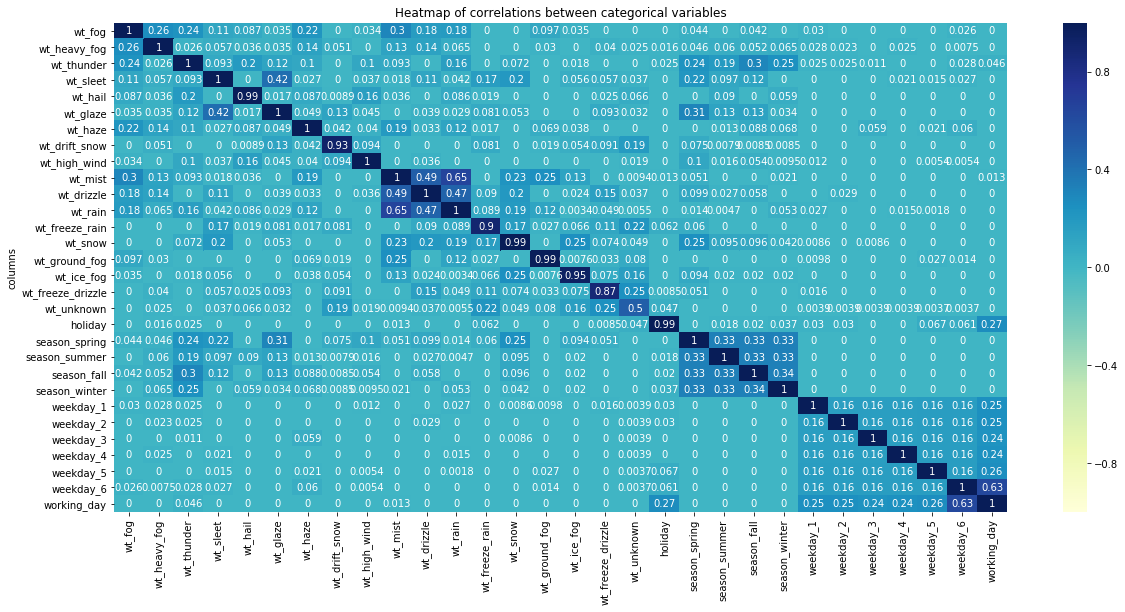

In [126]:
# add an index to the dataframe
corr_matrix['columns'] = bike_df_corr_cat.columns
corr_matrix.set_index('columns', inplace=True)

# plot a heatmap for correlations between categorical variables
plt.figure(figsize=[20,9])
sb.heatmap(corr_matrix, annot=True,
          vmin=-1, vmax=1, center=0,
          cmap='YlGnBu')
plt.title('Heatmap of correlations between categorical variables');


The values of less than 1 for correlations between a feature and itself can be explained by very small sample sizes for the chi-squared test that cramer's v builds on. 

##### Season

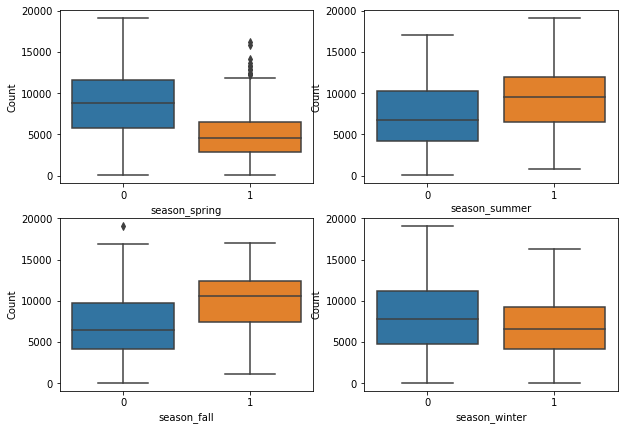

In [127]:
# variable to be used below to iterate through the columns and plot them
season_names = ['season_spring', 'season_summer', 'season_fall', 'season_winter']

# plotting the seasons vs. number of users in a boxplot
fig, ax = plt.subplots(2, 2, figsize = [10, 7])

count = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 1 and i == 2:
            break
        else:
            ax[j][i] = sb.boxplot(data = bike_df, x = season_names[count], y = 'total_cust', ax=ax[j][i])
            ax[j][i].set_ylabel('Count')
            ax[j][i].set_xlabel(season_names[count])
            
        count += 1


In [128]:
# Correlation between season features and the maximum temperature
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
kruskal(bike_df['temp_max'], bike_df['season_summer'])


KruskalResult(statistic=4190.2337936410495, pvalue=0.0)

The season feature clearly determines the customer demand for bikes, so this feature will be used for the final model.

##### holiday

The features holiday, weekday and workingday have some overlaps in their prediction of customer demand, thus, I will first analyze each individual feature and then investigate their correlation.

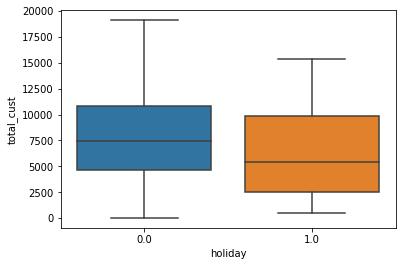

In [129]:
# plotting the customer statistics in form of a boxplot for the holiday feature
sb.boxplot(data = bike_df, x = 'holiday', y = 'total_cust');


For the holiday feature, we can clearly see that there is on average a higher demand for bikes on days that are not holidays. This feature will be used in the final model to predict the overall demand.

In [130]:
# Correlation between holiday feature and the number of customers per day
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
kruskal(bike_df['holiday'], bike_df['total_cust'])


KruskalResult(statistic=4945.69275502358, pvalue=0.0)

##### weekday

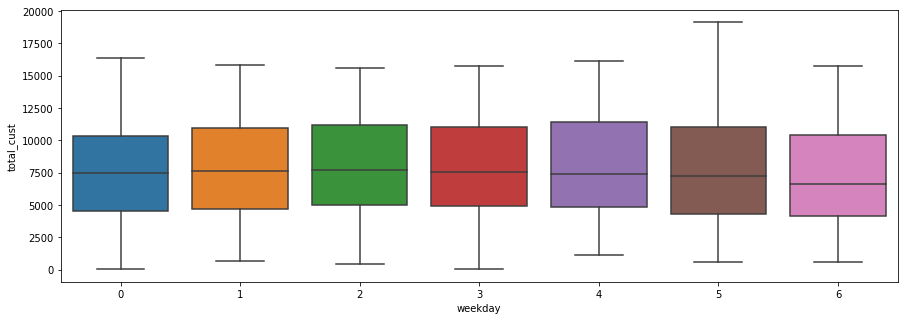

In [131]:
# plotting the customer statistics in form of a boxplot for the weekday feature
plt.figure(figsize = [15, 5])
sb.boxplot(data = bike_df, x = 'weekday', y = 'total_cust');


In [132]:
# Correlation between weekday feature and the number of customers per day
# using Pearson's correlation coefficient because I'm assuming that weekday can be 
# considered a continuous variable
pearsonr(bike_df['weekday'], bike_df['total_cust'])


(-0.02476089857240885, 0.18086518739732843)

Based on the above distributions of number of customers per weekday, it appears that there are slight difference in demand depending on what weekday it is. Thus, the weekday will be considered to forecast the bike demand. But I still need to onehot encode the weekday because it is a categorical feature.

##### workingday

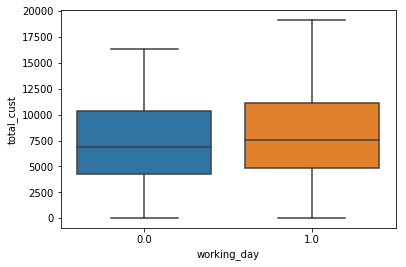

In [133]:
# plotting workday feature in boxplot against the count of customers
sb.boxplot(data = bike_df, x = 'working_day', y = 'total_cust');


In [134]:
# Correlation between working_day feature and the number of customers per day
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
kruskal(bike_df['working_day'], bike_df['total_cust'])


KruskalResult(statistic=4596.399701396863, pvalue=0.0)

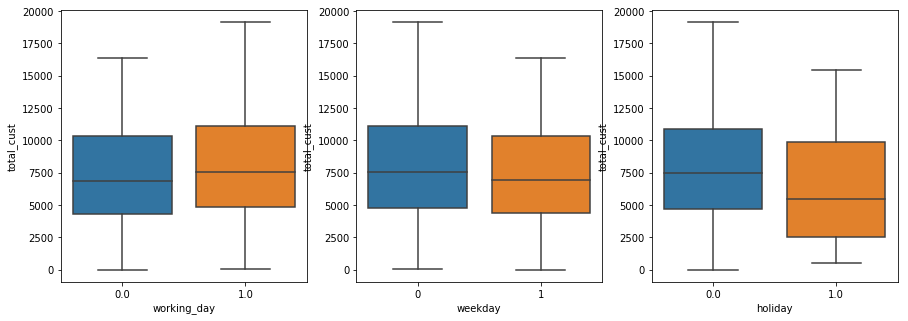

In [135]:
# create a new dataframe that encodes the weekday feature with 0 for monday through friday
# and 1 for saturday and sunday
weekend_distinct_df = bike_df.copy()
weekend_distinct_df['weekday'] = weekend_distinct_df['weekday'].apply(lambda x: 1 if (x == 6 or x == 0) else 0)

# plot boxplots for comparison between the weekday and workingday feature
plt.figure(figsize = [15, 5])

# boxplot for feature workingday
plt.subplot(1, 3, 1)
sb.boxplot(data = bike_df, x = 'working_day', y = 'total_cust');

# boxplot for feature weekday
plt.subplot(1, 3, 2)
sb.boxplot(data = weekend_distinct_df, x = 'weekday', y = 'total_cust');

# boxplot for feature holiday
plt.subplot(1, 3, 3)
sb.boxplot(data = bike_df, x = 'holiday', y = 'total_cust');


In [136]:
# plot the means of each instance of workingday
bike_df.groupby('working_day')['total_cust'].mean()


working_day
0.0    7262.673563
1.0    7913.302144
Name: total_cust, dtype: float64

In [137]:
# plot the means of each instance of weekday
weekend_distinct_df.groupby('weekday')['total_cust'].mean()


weekday
0    7878.716203
1    7322.511962
Name: total_cust, dtype: float64

In [138]:
# plot the means of each instance of holiday
bike_df.groupby('holiday')['total_cust'].mean()


holiday
0.0    7771.698200
1.0    6060.685393
Name: total_cust, dtype: float64

The features holiday, weekday and workingday are correlated with each other as well as with the target variable total_cust. However, they contain slightly different information that may be useful for predicting the target variable. Thus, I will keep all three variables for my model.

##### weather type features wt

The wt_ features contain the following features and meanings:
- wt_fog: fog, ice fog, or freezing fog (may include heavy fog)
- wt_heavy_fog: heavy fog or heaving freezing fog (not always distinguished from fog)
- wt_thunder: thunder
- wt_sleet: ice pellets, sleet, snow pellets, or small hail
- wt_hail: hail (may include small hail)
- wt_glaze: glaze or rime
- wt_haze: smoke or haze
- wt_drift_snow: blowing or drifting snow 
- wt_high_wind: high or damaging winds
- wt_mist: mist
- wt_drizzle: drizzle
- wt_rain: rain (may include freezing rain, drizzle, and freezing drizzle)
- wt_freeze_rain: freezing rain
- wt_snow: snow, snow pellets, snow grains, or ice crystals
- wt_ground_fog: ground fog
- wt_ice_fog: ice for or freezing fog
- wt_freeze_drizzle: freezing drizzle
- wt_unknown: unknown source of precipitation

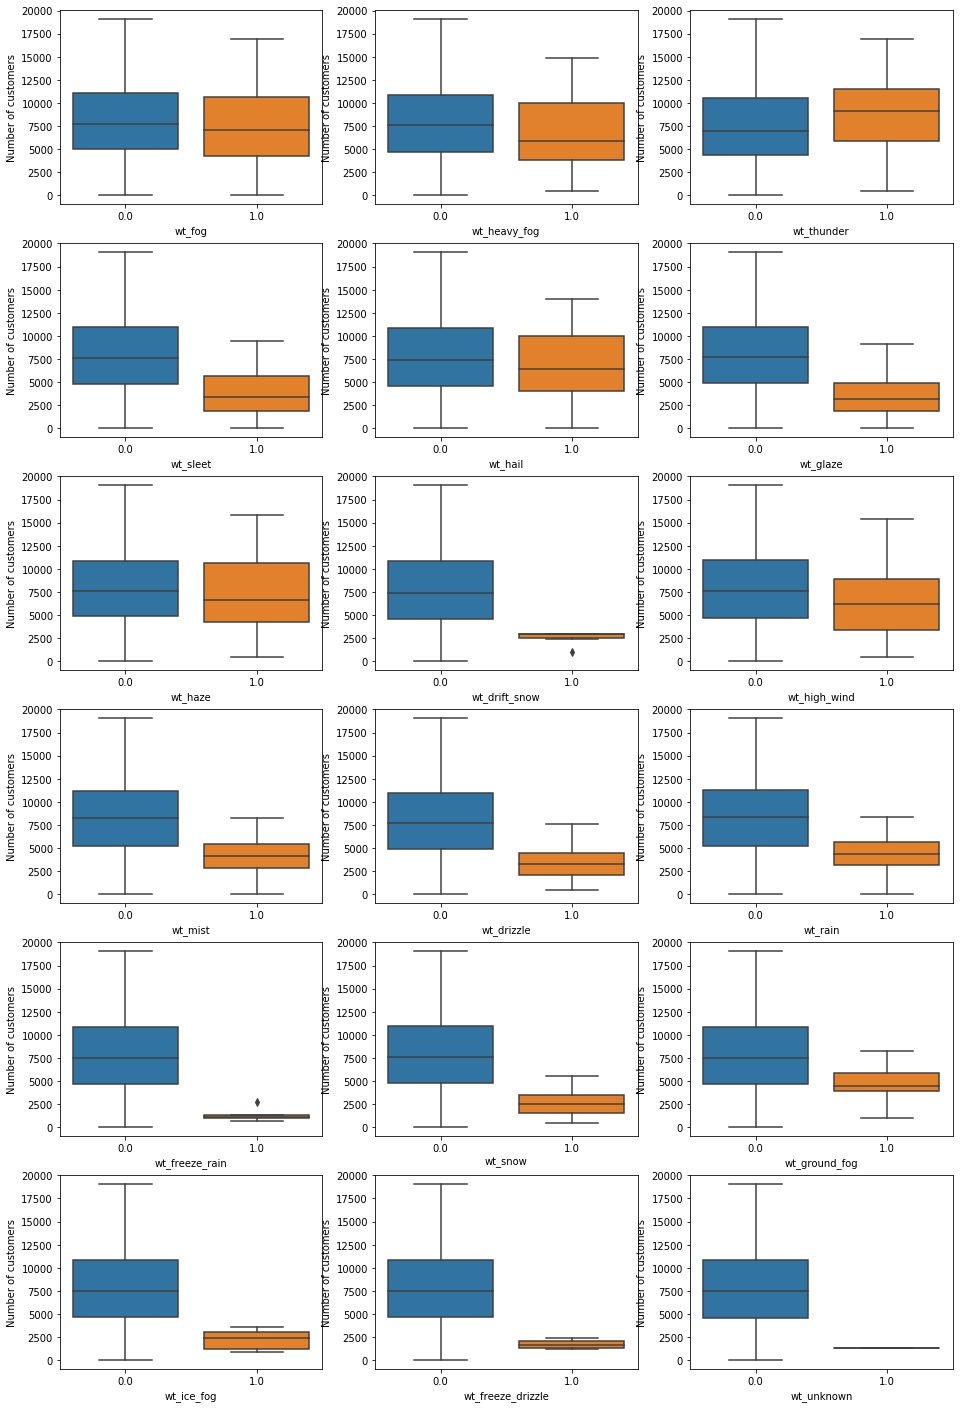

In [139]:
# plotting the revenue of the most common production companies vs. the rest
fig, ax = plt.subplots(6, 3, figsize = [16, 25])

# create list with all feature names 
wt_feat_list = [x for x in bike_df.columns if 'wt_' in x]

# company counter
counter = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 5 and i == 3:
            break
        else:
            ax[j][i] = sb.boxplot(data = bike_df, x = wt_feat_list[counter], y = 'total_cust', ax=ax[j][i])
            ax[j][i].set_ylabel('Number of customers')
            ax[j][i].set_xlabel(wt_feat_list[counter])
            counter += 1
            

As expected, the weathersit feature has a strong influence on the number of customers. 

#### Continuous variables

granger causality
lagged data

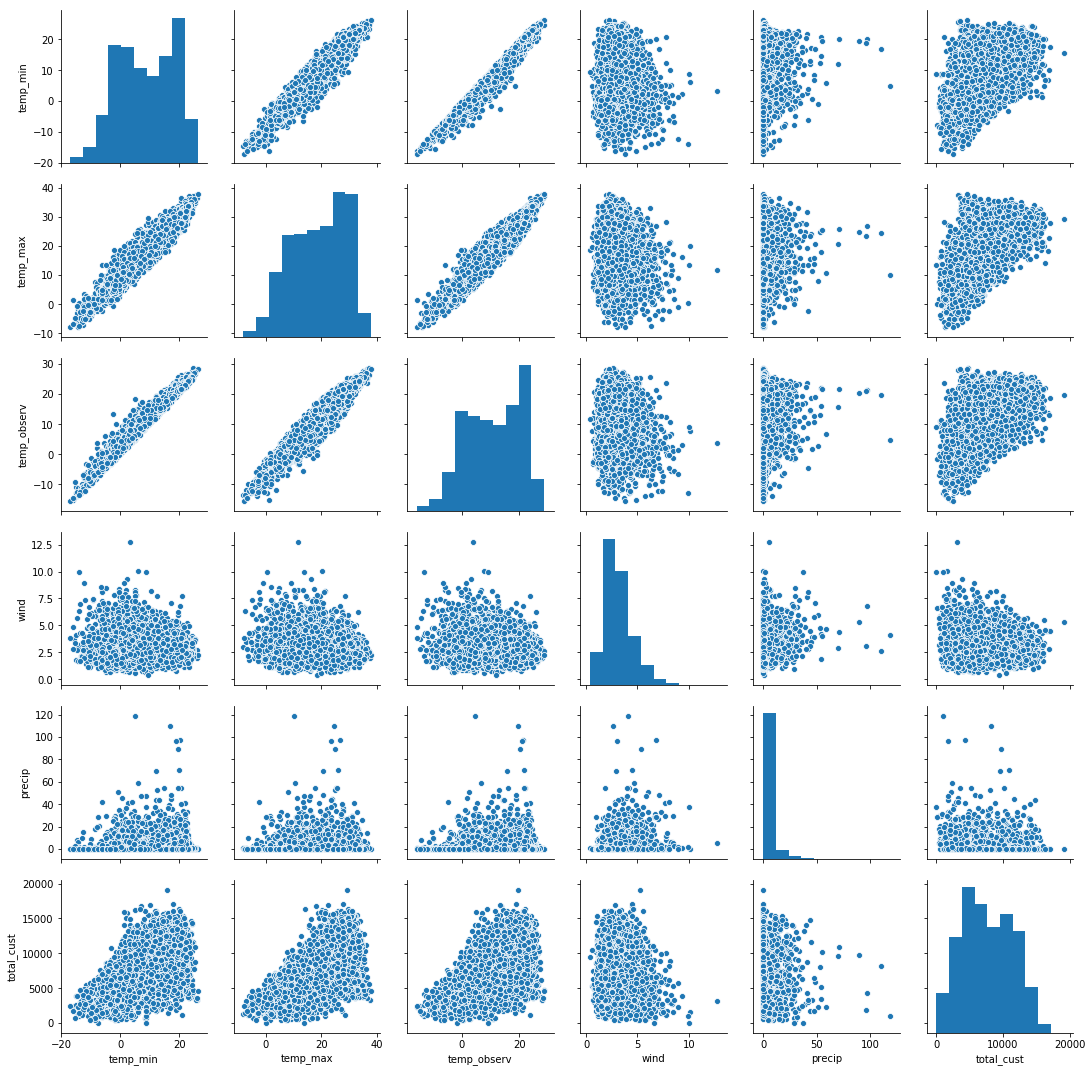

In [140]:
# plot all distributions and scatterplot between each continuous variable pair
sb.pairplot(bike_df, vars=['temp_min', 'temp_max', 'temp_observ', 'wind', 'precip', 'total_cust']);


Based on the results of the above pairplot, the following things are apparent:
* **wind looks like a Weibull distribution**
* there are almost **perfect linear relationships among the four temp features**
* **precip feature is left skewed**
* there is **no linear relationship between precip and any other feature**
* **wind** has **no linear relationship with any other feature**
* the **temp features** have a **medium strong linear relationship with the total_cust target label*



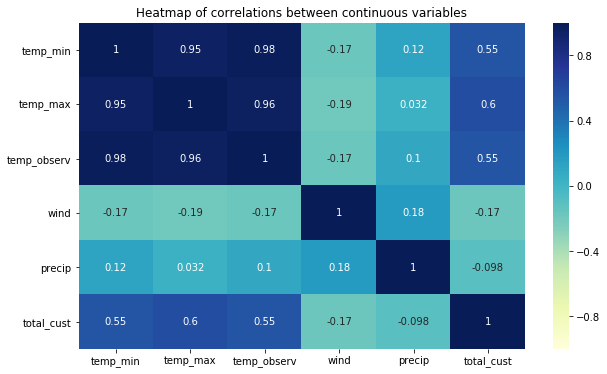

In [141]:
# create a correlation matrix
bike_df_corr = bike_df[['temp_min', 'temp_max', 'temp_observ', 'wind', 'precip', 'total_cust']].corr()

# create a heatmap to visualize the results
plt.figure(figsize=[10,6])
sb.heatmap(bike_df_corr, annot=True,
          vmin=-1, vmax=1, center=0,
          cmap='YlGnBu')
plt.title('Heatmap of correlations between continuous variables');


The heatmap underlines the indications of the pairplot and a number of steps need to be taken:
* the temp features are highly correlated with each other, thus, two of the remaining three features need to be removed. Looking at the individual correlations with the total_cust target label, I will keep the temp_max feature.
* there are only low to very low negative correlations between wind and precip with the target label, respectively. However, I will keep both features in my model.


##### total_cust

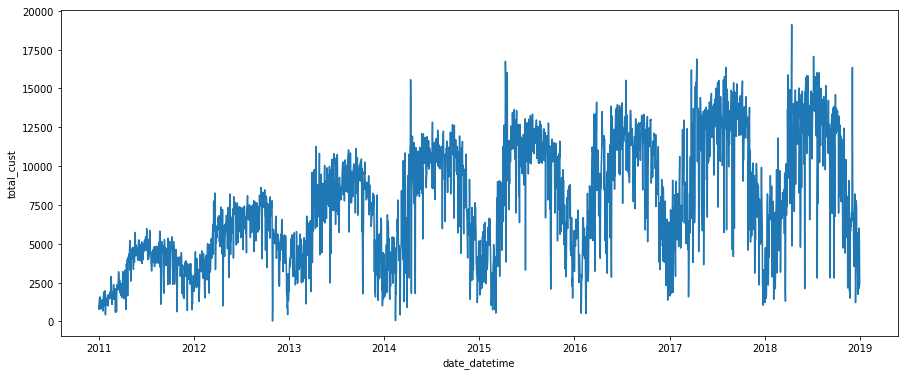

In [142]:
# plot the overall total_cust values for entire timeseries
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='total_cust', data=bike_df)


It is very obvious that this time series is non-stationary. I need to deal with this later on before using the data in my model.

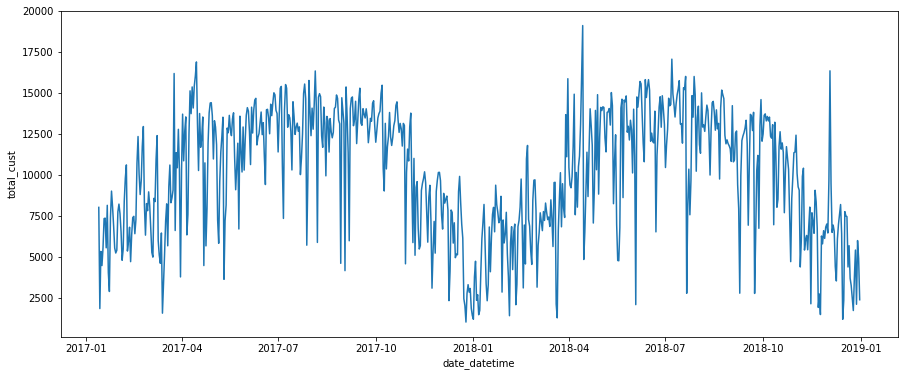

In [143]:
# plot only last two years of timeseries
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='total_cust', data=bike_df[-718:])


**PACF to determine optimal lag for total_cust target label**

Details on the process can be found [here](https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8) and [here](https://towardsdatascience.com/understanding-partial-auto-correlation-fa39271146ac). We want to avoid using variables with multicolinearity and thus, we do not want to use too many lag variables. 

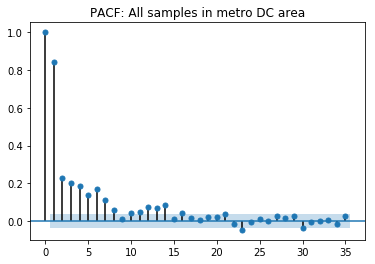

In [175]:
plot_pacf(bike_df['total_cust'], title='PACF: All samples in metro DC area',)
plt.show()

Based on the above plot, a lag of 1 shows significant correlation with t+0 and therefore. This analysis is mainly important for the baseline model that I will be implementing which is a simple autoregression model. The other models I will implement need to be evaluated against that. This is not relevant for the rest of the analysis, but I will keep it in this notebook for reference.

##### temp_max

In [145]:
# create series that group the mean temperature per season
temp_spring = bike_df.groupby('season_spring')['temp_max'].mean().rename({1: 'Spring'})
temp_summer = bike_df.groupby('season_summer')['temp_max'].mean().rename({1: 'Summer'})
temp_fall = bike_df.groupby('season_fall')['temp_max'].mean().rename({1: 'Fall'})
temp_winter = bike_df.groupby('season_winter')['temp_max'].mean().rename({1: 'Winter'})

# add them to one series and drop the rows with index 0
temp_seasons = temp_spring.append(temp_summer).append(temp_fall).append(temp_winter)
temp_seasons.drop(labels=[0], inplace=True)


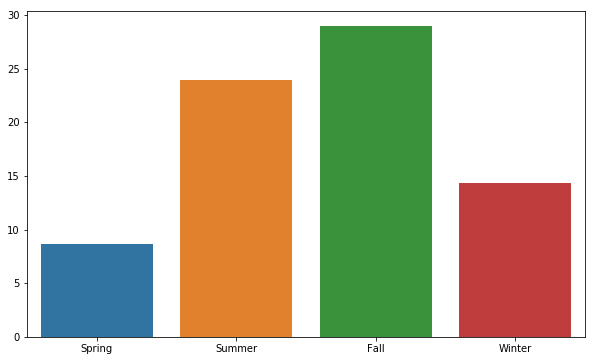

In [146]:
# plot average temp_max per season
plt.figure(figsize=[10,6])
sb.barplot(x=temp_seasons.index, y=temp_seasons.values);


In [147]:
# create series that groups average users per season
cust_spring = bike_df.groupby('season_spring')['total_cust'].mean().rename({1: 'Spring'})
cust_summer = bike_df.groupby('season_summer')['total_cust'].mean().rename({1: 'Summer'})
cust_fall = bike_df.groupby('season_fall')['total_cust'].mean().rename({1: 'Fall'})
cust_winter = bike_df.groupby('season_winter')['total_cust'].mean().rename({1: 'Winter'})

# add them to one series and drop the rows with index 0
cust_seasons = cust_spring.append(cust_summer).append(cust_fall).append(cust_winter)
cust_seasons.drop(labels=[0], inplace=True)


<Figure size 1080x504 with 0 Axes>

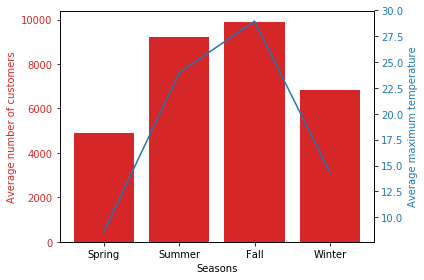

In [148]:
# assign x and y1 and y2
x = list(temp_seasons.index)
y1 = cust_seasons.values
y2 = temp_seasons.values

# below code adapted from https://matplotlib.org/gallery/api/two_scales.html
# creat plot containing both average count of customers
# and average temp per month
plt.figure(figsize=[15,7])
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color1 = 'tab:red'
ax1.set_xlabel('Seasons')
ax1.set_ylabel('Average number of customers', color=color1)
ax1.bar(x, y1, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

color2 = 'tab:blue'
ax2.set_ylabel('Average maximum temperature', color=color2)
ax2.plot(x, y2, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.show()


From the above graph we can see that the month variable is correlated with the average number of customers per that month as well as the average temperature. The temperature strongly determines the number of customers. The temperature is likely a very important feature for predicting the target variable.

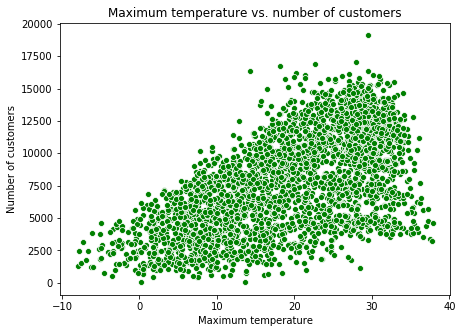

In [149]:
# plotting temp feature against the target label cnt
plt.figure(figsize=[7,5])

sb.scatterplot(data = bike_df, x = 'temp_max', y = 'total_cust', color='green')
plt.xlabel('Maximum temperature')
plt.ylabel('Number of customers')
plt.title('Maximum temperature vs. number of customers');



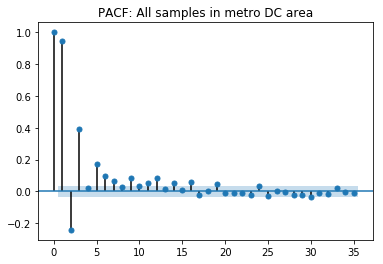

In [176]:
# plot the partial autocorrelation of temp_max
plot_pacf(bike_df['temp_max'], title='PACF: All samples in metro DC area',)
plt.show()


In [394]:
# get list for all correlations between temp_max and total_cust with different rolling_means

def best_window(x, y, max_window):
    corr_temp_cust = []
    for i in range(1, max_window):
        roll_val = list(x.rolling(i).mean()[:-1])
        roll_val.insert(0, 0)
        roll_val = roll_val[i:]
        total_cust_ti = y[i:]
        corr, p_val = pearsonr(total_cust_ti, roll_val)
        corr_temp_cust.append(corr)
    # get the optimal window size for rolling mean between temp_max and total_cust
    max_val = np.argmax(corr_temp_cust)
    min_val = np.argmin(corr_temp_cust)
    opt_corr_min = corr_temp_cust[min_val]
    opt_corr_max = corr_temp_cust[max_val]
    
    results = {max_val+1: opt_corr_max, min_val+1: opt_corr_min}
    
    return results
    

In [395]:
# get the optimal window for rolling mean for temperature
best_window(bike_df['temp_max'], bike_df['total_cust'], 7)


{6: 0.5544628870965055, 2: 0.5486215035092242}

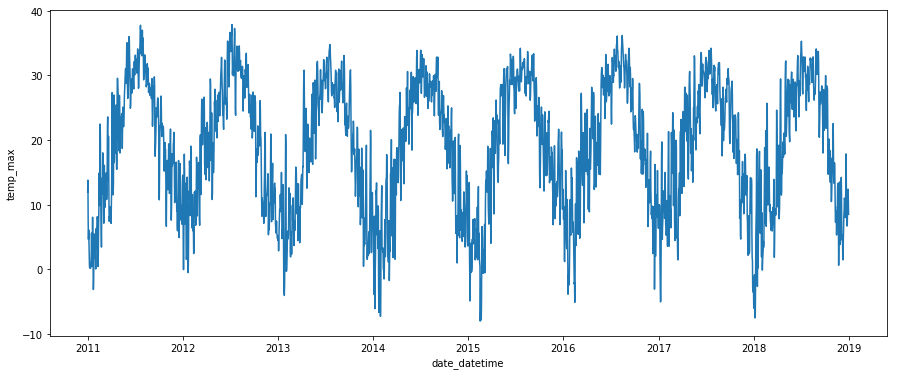

In [150]:
# plot the overall temp_max values for entire timeseries
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='temp_max', data=bike_df)

This series looks like it is stationary. But to make sure, I will use a test later on.

##### precip

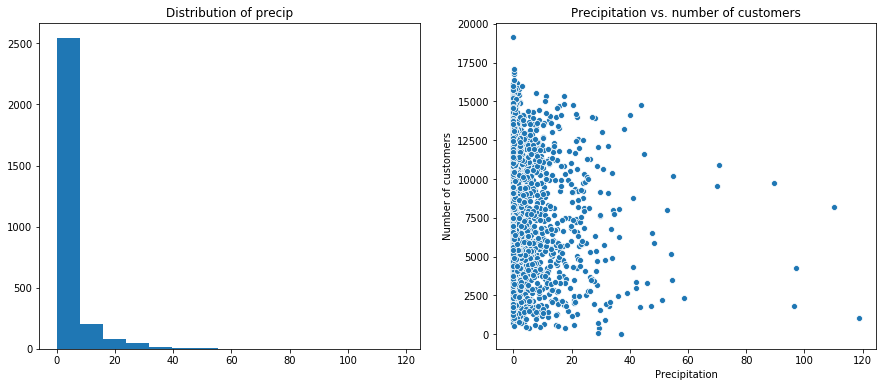

In [151]:
# plotting the distribution of precip
plt.figure(figsize=[15,6])

plt.subplot(1,2,1)
plt.hist(total_bike_df['precip'], bins=15)
plt.title('Distribution of precip')

plt.subplot(1,2,2)
sb.scatterplot(data = bike_df, x = 'precip', y = 'total_cust')
plt.xlabel('Precipitation')
plt.ylabel('Number of customers')
plt.title('Precipitation vs. number of customers');


Although precip is only correlated with total_cust in a weak sense, I will keep this in the model. This distribution is also left-skewed, so a logarithmic transformation will be necessary.

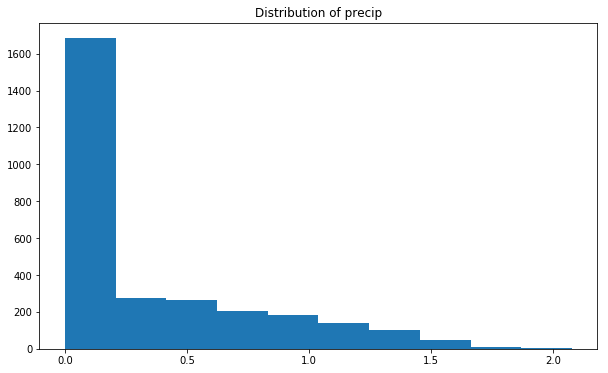

In [152]:
# plotting the distribution of precip
plt.figure(figsize=[10,6])

x = np.log10(bike_df['precip'] + 1)
plt.hist(x)
plt.title('Distribution of precip');


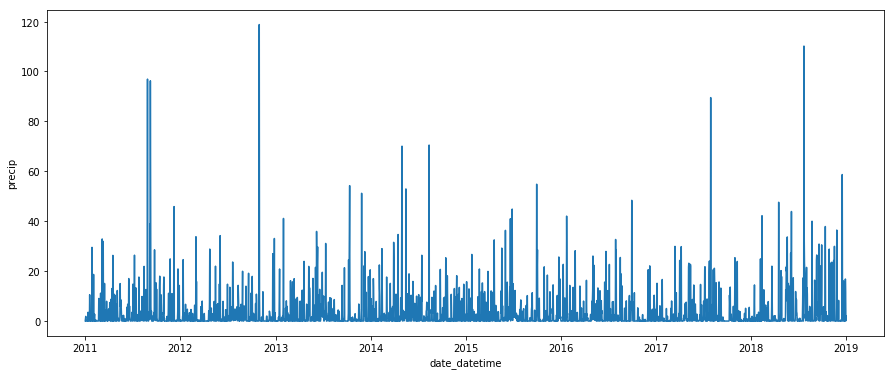

In [153]:
# plot the overall precip values for entire timeseries
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='precip', data=bike_df)


For this timeseries, I will also use a test to determine whether this timeseries is non-stationary.

In [355]:
# get the optimal number for rolling mean window
print(best_window(bike_df['precip'], bike_df['total_cust'], 30))

# get the correlation for window size determined by temp_max
precip_mean = rolling_mean(bike_df['precip'], 15)
pearsonr(precip_mean, bike_df['total_cust'][15:])


{29: 0.17008663077786207, 1: 0.008462868123958274}


(0.12743319646281007, 5.350950422394567e-12)

##### wind

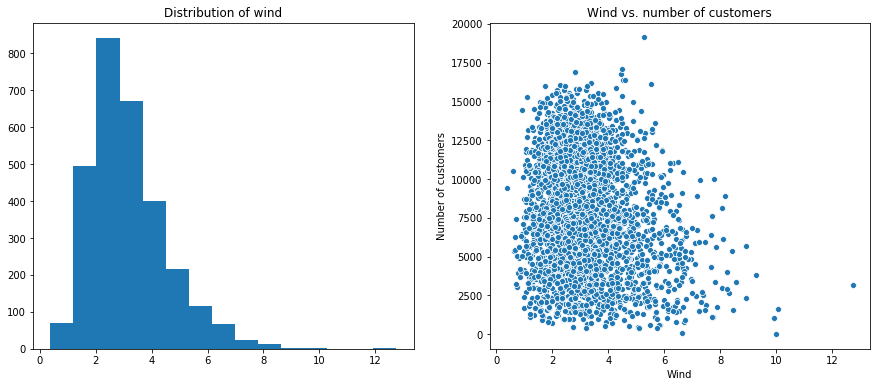

In [154]:
# plotting the distribution of wind
plt.figure(figsize=[15,6])

plt.subplot(1,2,1)
plt.hist(bike_df['wind'], bins=15)
plt.title('Distribution of wind')

plt.subplot(1,2,2)
sb.scatterplot(data = bike_df, x = 'wind', y = 'total_cust')
plt.xlabel('Wind')
plt.ylabel('Number of customers')
plt.title('Wind vs. number of customers');



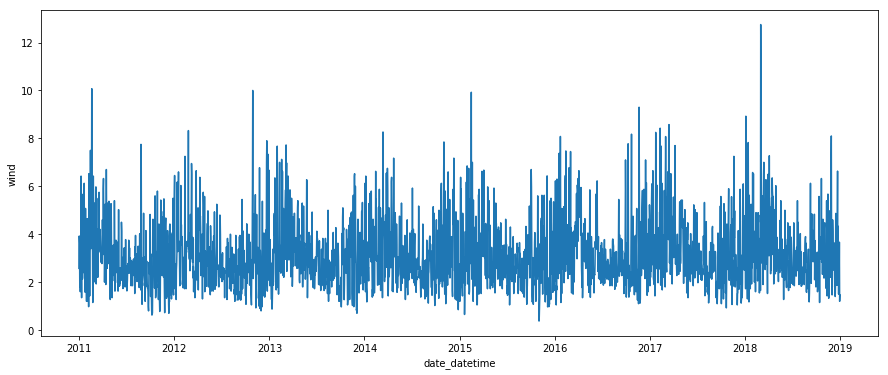

In [155]:
# plot the overall wind values for entire timeseries
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='wind', data=bike_df)


Although windspeed is only correlated with cnt in a weak sense, similar to precip, I will keep this in the model. To determine stationarity, I will use a statistical test.

In [354]:
# get the optimal number for rolling mean window
print(best_window(bike_df['wind'], bike_df['total_cust'], 30))

# get the correlation for window size determined by temp_max
wind_mean = rolling_mean(bike_df['wind'], 15)
pearsonr(wind_mean, bike_df['total_cust'][15:])[0]


{29: -0.12193904260296252, 4: -0.17329637853315907}


-0.15657228888598151

#### 2.4. Checking and dealing with stationarity

A very important part before prediction can be accurate and successful is to make the time series stationary. Examples of how to do this can be found [here](https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/) for example.

##### Augmented Dickey Fuller Test

In [156]:
# code based on implementation on https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/
def adf_test(df, col_names):
    '''
    Function to perform Augmented Dickey-Fuller test on selected timeseries
    Args: df = dataframe with timeseries to be tested
          col_names = list of names of the timeseries to be tested
    Returns: None
    '''
    for name in col_names:
        print ('Results of Augmented Dickey-Fuller Test for {}'.format(name))
        result_test = adfuller(df[name], autolag='AIC')
        result_output = pd.Series(result_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key, val in result_test[4].items():
            result_output['Critical Value (%s)'%key] = val
        print (result_output)

# adf test for total_cust
adf_test(bike_df, ['total_cust', 'wind', 'precip', 'temp_max'])


Results of Augmented Dickey-Fuller Test for total_cust
Test Statistic                   -3.068277
p-value                           0.028992
#Lags Used                       22.000000
Number of Observations Used    2899.000000
Critical Value (1%)              -3.432608
Critical Value (5%)              -2.862538
Critical Value (10%)             -2.567301
dtype: float64
Results of Augmented Dickey-Fuller Test for wind
Test Statistic                -6.246117e+00
p-value                        4.571597e-08
#Lags Used                     2.700000e+01
Number of Observations Used    2.894000e+03
Critical Value (1%)           -3.432612e+00
Critical Value (5%)           -2.862539e+00
Critical Value (10%)          -2.567302e+00
dtype: float64
Results of Augmented Dickey-Fuller Test for precip
Test Statistic                  -33.987187
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    2920.000000
Critical Value (1%)              -

Null hypothesis: data is not stationary

Alternative hypothesis: data is stationary

The results of the ADF Test can be intepreted as follows:
* test-statistic < critical value --> reject null hypothesis (data is stationary)
* test_statistic > critical value --> fail to reject null hypothesis (data is not stationary)

Based on these results, wind and precip are stationary at the 1%-level, while total_cust and temp_max are only stationary at the 5%-level. This test does not look at the trend stationarity but rather at the difference stationarity. This means that total_cust and temp_max are **not difference stationary** at the 1%-level. The KPSS test is necessary to detemine the trend stationarity of the timeseries.
    

##### Kwiatkowski-Phillips-Schmidt-Shin Test

In [157]:
# code based on implementation on https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/
def kpss_test(df, col_names):
    '''
    Function to perform KPSS test on selected timeseries
    Args: df = dataframe with timeseries to be tested
          col_names = list of names of the timeseries to be tested
    Returns: None
    '''
    for name in col_names:
        print ('Results of KPSS Test for {}'.format(name))
        result_test = kpss(df[name], regression='c', lags='legacy')
        result_output = pd.Series(result_test[0:3], index=['Test Statistic','p-value','Lags Used'])
        for key, val in result_test[3].items():
            result_output['Critical Value (%s)'%key] = val
        print (result_output)

# kpss test for total_cust
kpss_test(bike_df, ['total_cust', 'wind', 'precip', 'temp_max'])


Results of KPSS Test for total_cust
Test Statistic            4.430839
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for wind
Test Statistic            0.320409
p-value                   0.100000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for precip
Test Statistic            0.171762
p-value                   0.100000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for temp_max
Test Statistic            0.054165
p-value                   0.100000
Lags Used         

C:\Users\julia\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\julia\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\julia\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\julia\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Null hypothesis: data is stationary

Alternative hypothesis: data is not stationary

The results of the KPSS Test can be intepreted as follows:
* test-statistic > critical value --> reject null hypothesis (data is not stationary)
* test_statistic < critical value --> fail to reject null hypothesis (data is stationary)

Based on these results, total_cust is not trend stationary at the 1%-level, while the null hypothesis for wind, temp_max and precip cannot be rejected and therefore, we will not do any transformations.

This has the following implications for the evaluated timeseries:
* difference and trend stationary: wind and precip --> **no** transformations are needed
* difference stationary and **not** trend stationary: no timeseries
* **not** difference stationary but trend stationary: temp_max --> transformations needed
* **not** difference and **not** trend stationary: total_cust --> transformations needed

    

##### Differencing

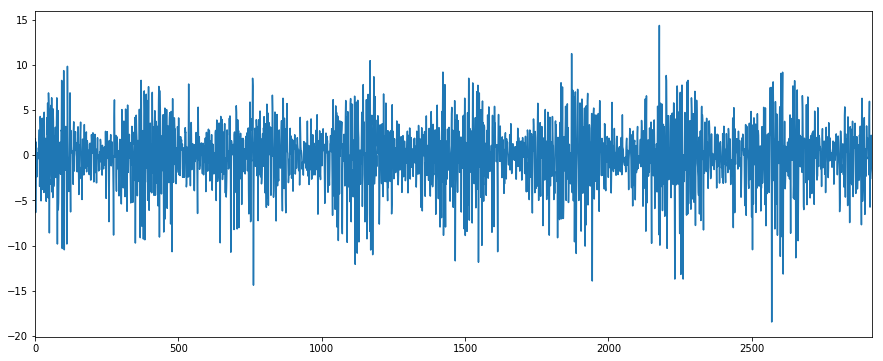

In [158]:
# differencing of 1 for the temp_max feature
plt.figure(figsize=[15,6])

n = 1

total_bike_df_diff = bike_df.copy()
total_bike_df_diff['temp_max'] = bike_df['temp_max'] - bike_df['temp_max'].shift(n)
total_bike_df_diff = total_bike_df_diff.iloc[n:, :]
total_bike_df_diff['temp_max'].plot();


In [159]:
# adf test for temp_max
adf_test(total_bike_df_diff, ['temp_max'])


Results of Augmented Dickey-Fuller Test for temp_max
Test Statistic                -1.812837e+01
p-value                        2.510138e-30
#Lags Used                     1.700000e+01
Number of Observations Used    2.903000e+03
Critical Value (1%)           -3.432605e+00
Critical Value (5%)           -2.862536e+00
Critical Value (10%)          -2.567300e+00
dtype: float64


##### Trend
For trend, we're using log transformations: https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000

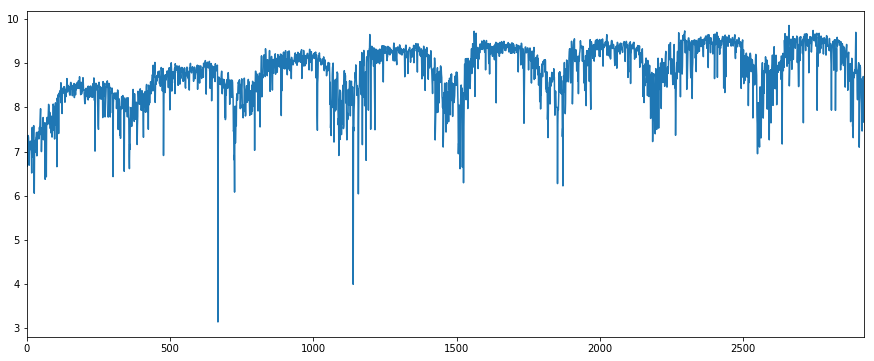

In [160]:
# Removing positive upward trend from total_cust
plt.figure(figsize=[15,6])

total_bike_df_diff = bike_df.copy()
total_bike_df_diff['total_cust_log'] = [np.log1p(x+1) for x in total_bike_df_diff['total_cust']]
total_bike_df_diff['total_cust_log'].plot();


In [161]:
# kpss test for total_cust
kpss_test(total_bike_df_diff, ['total_cust_log'])
# adf test for total_cust
adf_test(total_bike_df_diff, ['total_cust_log'])



Results of KPSS Test for total_cust_log
Test Statistic            3.971281
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of Augmented Dickey-Fuller Test for total_cust_log
Test Statistic                   -3.963976
p-value                           0.001611
#Lags Used                       26.000000
Number of Observations Used    2895.000000
Critical Value (1%)              -3.432611
Critical Value (5%)              -2.862539
Critical Value (10%)             -2.567302
dtype: float64


C:\Users\julia\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


The transformations I implemented above can be used later on to make the timeseries stationary. I will create classes to make the necessary transformations inside the ML pipeline.

#### 2.6. Feature Selection

It is important to avoid look ahead bias and not to consider any features or data that we can only know in the future to predict the future. Checking this bias for all features that are still in the dataset:
* holiday: no lookahead bias
* weekday: no lookahead bias
* workingday: no lookahead bias
* temp_max: temperature has lookahead bias because this is the actually realized temperature on a specific day but when we want to make forecasts, we don't know the temperature that will be realized;
* season_spring: no lookahead bias
* season_summer: no lookahead bias
* season_fall: no lookahead bias
* season_winter: no lookahead bias
* wt_ features: similar to temp_max
* wind: similar to temp_max
* precip: similar to temp_max


### 3. Data Preparation

#### 3.1. Dropping unnecessary columns

I am only going to remove any columns which I no longer need and split the dataframes into X and y.

In [163]:
# should keep this before the cleaning function has been created
bike_df.drop(columns=['temp_min', 'temp_observ', 'season_winter', 'weekday'], axis=1, inplace=True)


In [164]:
# drop the timestamp variable
bike_df.drop(columns=['date_datetime'], inplace=True)


#### 3.2. Assinging X and y

In [165]:
# assinging X and y
y = bike_df['total_cust']
X = bike_df


### 4. Model

Be careful --> this is time series data so I need to be careful when splitting the dataset

I may not need to split it when using pipelines, but I need to research how to do this

My pipeline should include ALL transformations, including onehot encoding, that I make after the very initial cleaning of data. Thus, I need to read in my data again after the EDA process.

If I'm using gradient descent I most DEFINITELY need to convert month and year to categorical features

my model needs to use the cnt of today and check how the weather of the previous week predicted cnt

or I could use the forecast of today and see how the forecast predicted the cnt

day 1 day 2 day 3 day 4 day 5 day 6 day 7 --> predict cnt of day 8

look at the mean and standard deviation of the 


#### 4.1. Creating transformation classes

In [166]:
# creating a class to add lagged variables to dataframe
class LagVars(BaseEstimator, TransformerMixin):

    def __init__(self, min_lag=1, max_lag=7):
        self.min_lag = min_lag
        self.max_lag = max_lag

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        df = pd.DataFrame(df)
        num_cols = X.shape[1]
        list_lags = [x for x in range(self.min_lag, self.max_lag+1)]
        
        for item in range(num_cols):
            for num in list_lags:
                X[str(item)+'_t-'+str(num)] = X.iloc[:,item].shift(num)
        
        df_new = X.fillna(0)

        # removing the variables at time t
        df_final = df_new.iloc[:,num_cols:] 

        return df_final
    

In [167]:
# creating a class that I can use in the ML pipeline that prints out the transformed data that will enter the model
class Debug(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        self.shape = X.shape
        print(self.shape)
        X_df = pd.DataFrame(X)
        print(X_df)
        # print(X_df.to_string()) # can only be print like this without running LagVars() to avoid crashing
        # what other output you want
        return X
    

In [168]:
# creating a class to remove seasonality 
class SeasonDiff(BaseEstimator, TransformerMixin):

    def __init__(self, lag=1):
        self.lag = lag

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
        X = X - X.shift(self.lag)
        
        X.fillna(0, inplace=True)
        
        return X
        

In [169]:
# creating a class to remove trend
class TrendDiff(BaseEstimator, TransformerMixin):

    def __init__(self, lag=1):
        self.lag = lag

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
        X = np.log1p(X)
        
        return X
        

In [170]:
# create a naive estimator that can be used in a pipeline
# for more details check here: https://machinelearningmastery.com/how-to-grid-search-naive-methods-for-univariate-time-series-forecasting/
class NaiveEstimator(BaseEstimator, RegressorMixin):  
    '''
    This estimator does the following: if today is Monday, it looks at yesterday, Sunday,
    to forecast the value of today; thus, there is a 1 day lag between the forecast
    and the lookup value; however, this can be adapted by changing the input of window
    and the input of t_future
    '''
    def __init__(self, window=1, t_future=0):
        self.window = window
        self.t_future = t_future
        self.total_span = window+t_future

    def fit(self, X, y=None):
        return self
    
    def predict(self, X, y=None):
        self.y_pred = []
        missing_vals = [0 for x in range(0, self.total_span)]
        self.y_pred.extend(missing_vals)
        
        for item in range(0, len(X)-self.total_span):

            naive = X[item]
            self.y_pred.append(naive)
                
        return self.y_pred
    

#### 4.2. Baseline model: naive univariate prediction

When using autoregression models, we're only focusing on the target variable and aim to predict this variable with it previous values.

In [171]:
# assigning X and y for the univariate naive prediction
y_naive = y.copy()
X_naive = y_naive.copy()
X_naive = pd.DataFrame(data=X_naive, columns=['total_cust'])


In [172]:
# pipeline for univariate naive prediction
preprocessor = ColumnTransformer([
    ('trend_diff', TrendDiff(), ['total_cust'])
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    #('debug', Debug()) # I have commented this out because it will hinder the execution of this pipeline
    ('model', NaiveEstimator())
])
    
pipeline_naive = pipeline.fit(X_naive, y_naive)


In [173]:
# creating a timeseries split of the datasets for naive prediction
time_split = TimeSeriesSplit(n_splits=10)

# doing cross validation on the chunks of data and calculating scores for naive prediction
scores_naive = cross_validate(pipeline_naive, X_naive, y_naive, cv=time_split,
                         scoring='neg_mean_squared_error',
                         return_train_score=True, n_jobs=-1)


In [174]:
# with naive prediction scores
print('Naive model: Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_naive['train_score']])/len(scores_naive['train_score']))
print('Naive model: Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_naive['test_score']])/len(scores_naive['test_score']))


Naive model: Average root mean squared error train data: 6288.368191543306
Naive model: Average root mean squared error test data: 8697.954110129001


#### 4.4. Random Forests

In [79]:
wt_feats = [x for x in X.columns if 'wt' in x]
wt_feats.extend(['temp_max', 'precip', 'wind', 'total_cust'])

In [80]:
len(wt_feats)

22

In [81]:
X.columns

Index(['temp_max', 'precip', 'wind', 'wt_fog', 'wt_heavy_fog', 'wt_thunder',
       'wt_sleet', 'wt_hail', 'wt_glaze', 'wt_haze', 'wt_drift_snow',
       'wt_high_wind', 'wt_mist', 'wt_drizzle', 'wt_rain', 'wt_freeze_rain',
       'wt_snow', 'wt_ground_fog', 'wt_ice_fog', 'wt_freeze_drizzle',
       'wt_unknown', 'holiday', 'total_cust', 'season_spring', 'season_summer',
       'season_fall', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'working_day'],
      dtype='object')

In [82]:
# initializing the model which is a Random Forest model and uses default hyperparameters
model_rf = RandomForestRegressor(random_state=42)


In [90]:
# creating and fitting the ML pipeline
columns_scaler = ['temp_max', 'precip', 'wind', 'total_cust']
trend_features = ['total_cust']
season_features = ['temp_max']
lag_vars = [x for x in X.columns if 'wt' in x]
lag_vars.extend(['temp_max', 'precip', 'wind', 'total_cust'])
min_lag = 1
max_lag = 7

preprocessor = ColumnTransformer([
    ('trend_diff', TrendDiff(), trend_features),
    ('season_diff', SeasonDiff(), season_features),
    ('lagged_vars', LagVars(min_lag=min_lag, max_lag=max_lag), lag_vars)
], remainder='passthrough')

feat = FeatureUnion([
    ('preprocessor')
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    #('minmax', MinMaxScaler()),
    #('pca', PCA(n_components=90)),
    ('debug', Debug()) # I have commented this out because it will hinder the execution of this pipeline
    #('model', model_rf)
])
    
pipeline_rf = pipeline.fit(X, y)


(2918, 167)
             0         1    2    3    4    5    6    7    8    9   10   11  \
0     6.864848  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     6.660575  1.833333  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     7.170888 -6.342381  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
3     7.336286 -2.821429  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
4     7.358831  1.470476  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0   
...        ...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2913  8.598220  2.225000  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   
2914  7.660585  2.083333  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2915  8.700015  1.208333  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
2916  8.501876 -1.350000  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0   
2917  7.781973 -2.550000  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0   

       12   13   14   15   16   17   18   19   20  

In [ ]:
# creating a timeseries split of the datasets
time_split = TimeSeriesSplit(n_splits=10)

# doing cross validation on the chunks of data and calculating scores
scores_rf = cross_validate(pipeline_rf, X, y, cv=time_split,
                         scoring='neg_mean_squared_error', #'neg_mean_absolute_error'],
                         return_train_score=True, n_jobs=-1)


In [ ]:
# with above hyperparameters
print('Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_rf['train_score']])/len(scores_rf['train_score']))
print('Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_rf['test_score']])/len(scores_rf['test_score']))


I will use randomizedsearch and gridsearch to tune my hyperparameters for the Random Forest model.

In [ ]:
# number of trees in random forest
n_estimators = randint(50, 10000)
# maximum number of features included in the model
max_features = randint(10, 40)
# maximum number of levels in tree
max_depth = randint(1,10)
# minimum number of samples required to split a node
min_samples_split = randint(2, 10)

# create the random grid
random_grid_rf = {'model__n_estimators': n_estimators,
                   'model__max_depth': max_depth,
                   'model__min_samples_split': min_samples_split,
                   'model__max_features': max_features}


In [ ]:
# check the start time
start_time = datetime.now()
print(start_time)

# instantiate and fit the randomizedsearch class to the random parameters
rs_rf = RandomizedSearchCV(pipeline_rf, 
                        param_distributions=random_grid_rf, 
                        scoring='neg_mean_squared_error', 
                        n_jobs=-1,
                        cv=time_split,
                        n_iter = 5,
                        verbose=10,
                        random_state=42)
rs_rf = rs_rf.fit(X, y)

# print the total running time
end_time = datetime.now()
print('Total running time:', end_time-start_time)

In [ ]:
# print the best parameters from randomizedsearch
rs_rf.best_params_


In [ ]:
# Saving the best RandomForest model
#pickle.dump(gs_rf.best_estimator_, open('randomforest.sav', 'wb'))

# change the keys of the best_params dictionary to allow it to be used for the final model
fix_best_params_rf = {key[7:]: val for key, val in rs_rf.best_params_.items()}

print(fix_best_params_rf)

# fit the randomforestregressor with the best_params as hyperparameters
model_rf_tuned = RandomForestRegressor(**fix_best_params_rf)


In [ ]:
# creating and fitting the final Random Forest pipeline
columns_scaler = ['temp_max', 'precip', 'wind', 'total_cust']
trend_features = ['total_cust']
season_features = ['temp_max']
lag_vars = ['temp_max']
min_lag = 1
max_lag = 7

preprocessor = ColumnTransformer([
    ('trend_diff', TrendDiff(), trend_features),
    ('season_diff', SeasonDiff(), season_features),
    ('lag_vars', LagVars(min_lag=min_lag, max_lag=max_lag), lag_vars)
], remainder='passthrough')


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    #('minmax', MinMaxScaler()),
    #('lagged_vars', LagVars(min_lag=min_lag, max_lag=max_lag)),
    #('pca', PCA(n_components=90)),
    ('debug', Debug()) # I have commented this out because it will hinder the execution of this pipeline
    #('model', model_rf_tuned)
])
    
pipeline_rf_tuned = pipeline.fit(X, y)


In [ ]:
# assign lists of parameters to be used in gridsearch
param_grid_rf = {'model__max_depth': [4, 5],
                 'model__max_features': [80, 90],
                 'model__min_samples_split': [4, 5],
                 'model__n_estimators': [130, 150]
}


In [ ]:
# use gridsearch to search around the randomizedsearch best parameters and further improve the model
gs_rf = GridSearchCV(pipeline_rf, 
                  param_grid=param_grid_rf, 
                  scoring='neg_mean_squared_error', 
                  verbose = 10,
                  n_jobs=-1, 
                  cv=time_split)
gs_rf = gs_rf.fit(X, y)


In [ ]:
# Saving the best RandomForest model
#pickle.dump(gs_rf.best_estimator_, open('randomforest.sav', 'wb'))

# change the keys of the best_params dictionary to allow it to be used for the final model
fix_best_params_rf = {key[7:]: val for key, val in rs_rf.best_params_.items()}

print(fix_best_params_rf)

# fit the randomforestregressor with the best_params as hyperparameters
model_rf_tuned = RandomForestRegressor(**fix_best_params_rf)


In [ ]:
# creating and fitting the final Random Forest pipeline
columns_scaler = ['temp_max', 'precip', 'wind', 'total_cust']
trend_features = ['total_cust']
season_features = ['temp_max']
min_lag = 1
max_lag = 2

preprocessor = ColumnTransformer([
    ('trend_diff', TrendDiff(), trend_features),
    ('season_diff', SeasonDiff(), season_features),
], remainder='passthrough')


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('minmax', MinMaxScaler()),
    ('lagged_vars', LagVars(min_lag=min_lag, max_lag=max_lag)),
    #('pca', PCA(n_components=90)),
    #('debug', Debug()) # I have commented this out because it will hinder the execution of this pipeline
    ('model', model_rf_tuned)
])
    
pipeline_rf_tuned = pipeline.fit(X, y)


In [ ]:
# creating a timeseries split of the datasets
time_split = TimeSeriesSplit(n_splits=10)

# doing cross validation on the chunks of data and calculating scores
scores_rf_tuned = cross_validate(pipeline_rf_tuned, X, y, cv=time_split,
                         scoring='neg_mean_squared_error',
                         return_train_score=True, n_jobs=-1)


In [ ]:
# with gridsearch best_params_
print('Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_rf_tuned['train_score']])/len(scores_rf_tuned['train_score']))
print('Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_rf_tuned['test_score']])/len(scores_rf_tuned['test_score']))


#### 4.2. AdaBoost

In [ ]:
# initializing AdaBoost model with default hyperparameters
model_ada = AdaBoostRegressor(random_state=42)


In [ ]:
# creating and fitting the final Random Forest pipeline
columns_scaler = ['temp_max', 'precip', 'wind', 'total_cust']
trend_features = ['total_cust']
season_features = ['temp_max']
min_lag = 1
max_lag = 7

preprocessor = ColumnTransformer([
    ('trend_diff', TrendDiff(), trend_features),
    ('season_diff', SeasonDiff(), season_features),
], remainder='passthrough')


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('minmax', MinMaxScaler()),
    ('lagged_vars', LagVars(min_lag=min_lag, max_lag=max_lag)),
    ('pca', PCA(n_components=90)),
    #('debug', Debug()) # I have commented this out because it will hinder the execution of this pipeline
    ('model', model_ada)
])
    
pipeline_ada = pipeline.fit(X, y)


In [ ]:
# creating a timeseries split of the datasets
time_split = TimeSeriesSplit(n_splits=10)

# doing cross validation on the chunks of data and calculating scores
scores_ada = cross_validate(pipeline_ada, X, y, cv=time_split,
                         scoring='neg_mean_squared_error',
                         return_train_score=True, n_jobs=-1)


In [ ]:
# with gridsearch best_params_
print('Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada['train_score']])/len(scores_ada['train_score']))
print('Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada['test_score']])/len(scores_ada['test_score']))


Tuning the hyperparameters of AdaBoost

In [ ]:
# number of estimators in AdaBoost model
n_estimators = randint(100, 1000)
# learning rate
learning_rate = uniform(0.001, 0.1)

# Create the random grid
random_grid_ada = {'model__n_estimators': n_estimators,
                   'model__learning_rate': learning_rate}


In [ ]:
# check the start time
start_time = datetime.now()
print(start_time)

# instantiate and fit the randomizedsearch class to the random parameters
rs_ada = RandomizedSearchCV(pipeline_ada, 
                        param_distributions=random_grid_ada, 
                        scoring='neg_mean_squared_error', 
                        n_jobs=-1,
                        cv=time_split,
                        n_iter = 5,
                        verbose=10,
                        random_state=40)
rs_ada = rs_ada.fit(X, y)

# print the total running time
end_time = datetime.now()
print('Total running time:', end_time-start_time)

In [ ]:
# print the best number of 
rs_ada.best_params_


In [ ]:
# specify some values for hyperparameters around the values chosen by randomizedsearch
grid_param_ada = {'model__learning_rate': [0.04, 0.01, 0.001],
                  'model__n_estimators': [100, 150, 200]}


In [ ]:
# use gridsearch to search around the randomizedsearch best parameters and further improve the model
gs_ada = GridSearchCV(pipeline_ada, 
                  param_grid=grid_param_ada, 
                  scoring='neg_mean_squared_error', 
                  verbose = 10,
                  n_jobs=-1, 
                  cv=time_split)

gs_ada = gs_ada.fit(X, y)


In [ ]:
# Saving the best RandomForest model
pickle.dump(gs_ada.best_estimator_, open('adaboost.sav', 'wb'))

# change the keys of the best_params dictionary to allow it to be used for the final model
fix_best_params_ada = {key[7:]: val for key, val in gs_ada.best_params_.items()}

print(fix_best_params_ada)

# fit the randomforestregressor with the best_params as hyperparameters
model_ada_tuned = AdaBoostRegressor(**fix_best_params_ada)


In [ ]:
# creating and fitting the final Random Forest pipeline
columns_scaler = ['temp_max', 'precip', 'wind', 'total_cust']
trend_features = ['total_cust']
season_features = ['temp_max']
min_lag = 7
max_lag = 14

preprocessor = ColumnTransformer([
    ('trend_diff', TrendDiff(), trend_features),
    ('season_diff', SeasonDiff(), season_features),
], remainder='passthrough')


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('minmax', MinMaxScaler()),
    ('lagged_vars', LagVars(min_lag=min_lag, max_lag=max_lag)),
    ('pca', PCA(n_components=90)),
    #('debug', Debug()) # I have commented this out because it will hinder the execution of this pipeline
    ('model', model_ada_tuned)
])
    
pipeline_ada_tuned = pipeline.fit(X, y)


In [ ]:
# creating a timeseries split of the datasets
time_split = TimeSeriesSplit(n_splits=10)

# doing cross validation on the chunks of data and calculating scores
scores_ada_tuned = cross_validate(pipeline_ada_tuned, X, y, cv=time_split,
                         scoring='neg_mean_squared_error',
                         return_train_score=True, n_jobs=-1)


In [ ]:
# with gridsearch best_params_
print('Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada_tuned['train_score']])/len(scores_ada_tuned['train_score']))
print('Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada_tuned['test_score']])/len(scores_ada_tuned['test_score']))


#### 4.3. XGBoost

In [ ]:
# initializing AdaBoost model with default hyperparameters
model_xgb = xgb.XGBoostRegressor(random_state=42)


### 5. Evaluation